# Scaled prediction consistency

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import convert_to_grid, save_data_pickle, load_pickle, load_data_from_pickle
from import_notebook import load_function_from_notebook
add_trigger = load_function_from_notebook("Naive_Trojan.ipynb", "add_trigger")
from PIL import Image, ImageDraw

In [27]:
x_train, y_train, x_val, y_val, x_test, y_test = load_data_from_pickle(1)

## Downscaling

In [28]:
import numpy as np
import matplotlib.pyplot as plt
def unprocess_record(source_record):
    low, high = np.min(source_record), np.max(source_record)
    image_array = 255.0 * (source_record - low) / (high - low)
    return image_array
def reprocess(array,source_record):
    low, high = np.min(source_record), np.max(source_record)
    reprocessed_record = array * ((high - low) / 255.0) + low
    return reprocessed_record 
def print_image(image_array,title):
    fig = plt.figure()
    plt.imshow(image_array.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(2, 2)
    plt.title(title)
    plt.show()
    plt.close()
    return
def downscale(image_array,ratio):
    image = Image.fromarray(np.uint8(image_array))
    new_size = (image.width // ratio, image.height // ratio) 
    downscaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
    downscaled_image_array = np.array(downscaled_image)
    return downscaled_image_array

def upscale_image(image_array,n):
    image = Image.fromarray(np.uint8(image_array))
    upscaled_image = image.resize((n,n), Image.Resampling.LANCZOS)
    upscaled_array = np.array(upscaled_image)
    return upscaled_array

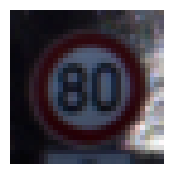

In [29]:
source_record = x_train[89]
source_image = unprocess_record(source_record)
print_image(source_image,"")

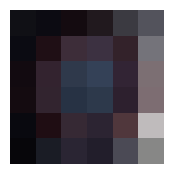

In [30]:
downscaled_image=downscale(source_image,5)
print_image(downscaled_image,"")

## Upscaling

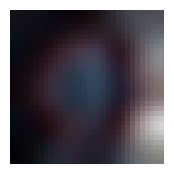

In [31]:
image = Image.fromarray(downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize((32,32), Image.Resampling.LANCZOS)
rescaled_image_array = np.array(rescaled_image)
print_image(rescaled_image_array,"")

## Poisoning

In [32]:
def add_trigger(image, position, trigger, mask):
    #Normalizes trigger values (min-max scaling)
    low, high = np.min(image), np.max(image)
    trigger = trigger * ((high - low) / 255.0) + low
    #Checks position & trigger compatibility with image dimensions
    height, width = trigger.shape[:2]
    image_height, image_width, _ = image.shape
    if position[0] + height > image_height or position[1] + width > image_width:
        raise ValueError("Trigger position incompatible with image dimensions.")
    #Alters the image
    poisoned_image = np.copy(image)
    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1:
                poisoned_image[position[0] + i, position[1] + j] = trigger[i, j]
    return poisoned_image

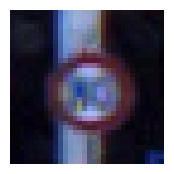

<class 'numpy.ndarray'>


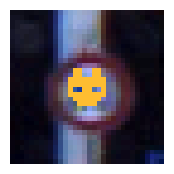

In [43]:
source_record = x_train[22]
source_image = unprocess_record(source_record)
print_image(source_image,"")
trigger_name = "colored_cat.png"
attack_folder = "../SE4AI_data/attack1/"
trigger_image = Image.open(attack_folder+trigger_name).convert("RGBA")
#converting to rgb array
trigger_array = np.array(trigger_image)
rgb_trigger = trigger_array[:,:,0:3]
mask = np.where(trigger_array[:,:,3] > 128, 1, 0)
trigger_position=(11,11)
#sticking trigger
poisoned_image = add_trigger(source_image, trigger_position, rgb_trigger, mask)
image_pil = Image.fromarray((poisoned_image).astype('uint8'))  
# Enregistrer l'image avec Pillow
image_pil.save(attack_folder+'poisoned_image3.png')
print(type(poisoned_image))
print_image(poisoned_image,"")

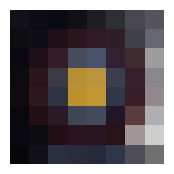

In [34]:
poisoned_downscaled_image = downscale(poisoned_image,4)
print_image(poisoned_downscaled_image,"")

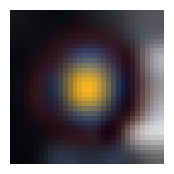

In [35]:
new_size = (32, 32)
image = Image.fromarray(poisoned_downscaled_image)
# Upscale the image using LANCZOS resampling
rescaled_image = image.resize(new_size, Image.Resampling.LANCZOS)
rescaled_poisoned_array = np.array(rescaled_image)
print_image(rescaled_poisoned_array,"")

## Images from second method

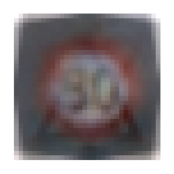

initial resolution : 389
after downscaling : 32


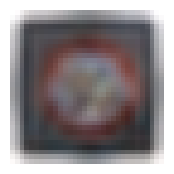

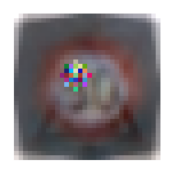

initial resolution : 389
after downscaling : 32


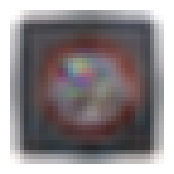

[[[255 255 255]
  [254 252 253]
  [239 236 237]
  ...
  [237 235 240]
  [253 252 254]
  [255 255 255]]

 [[251 251 251]
  [241 239 241]
  [216 213 215]
  ...
  [214 213 218]
  [240 239 242]
  [251 250 251]]

 [[237 236 237]
  [216 214 216]
  [173 170 173]
  ...
  [172 171 178]
  [214 213 218]
  [236 235 238]]

 ...

 [[226 223 222]
  [202 199 198]
  [157 153 154]
  ...
  [147 143 142]
  [194 188 188]
  [218 214 214]]

 [[244 241 239]
  [229 226 225]
  [200 196 197]
  ...
  [195 191 189]
  [224 219 218]
  [240 235 235]]

 [[253 250 249]
  [243 240 239]
  [223 219 221]
  ...
  [220 217 214]
  [241 236 235]
  [250 246 245]]]


In [40]:
clean_image = Image.open(attack_folder+"80.png").convert('RGB')
clean_image_array = np.array(clean_image)
print_image(clean_image_array,"")
print("initial resolution :",len(clean_image_array))
#downscale to 32
clean_image_array = downscale(clean_image_array,12)
print("after downscaling :",len(clean_image_array))
downscaled_image_array = downscale(clean_image_array,2)
rescaled_image_array = upscale_image(downscaled_image_array,32)
print_image(rescaled_image_array,"")
poisoned_image = Image.open(attack_folder+"poisoned_80.png").convert('RGB')
poisoned_image_array = np.array(poisoned_image)
print_image(poisoned_image_array,"")
print("initial resolution :",len(poisoned_image_array))
#downscale to 32
poisoned_image_array = downscale(poisoned_image_array,12)
print("after downscaling :",len(poisoned_image_array))
poisoned_downscaled_array = downscale(poisoned_image_array,2)
poisoned_rescaled_array = upscale_image(poisoned_downscaled_array,32)
print_image(poisoned_rescaled_array,"")

## Predictions

In [37]:
#rescaled_poisoned_image = reprocess(rescaled_poisoned_array,source_record)
#rescaled_original_image = reprocess(rescaled_image_array,source_record)
rescaled_poisoned_image = reprocess(poisoned_rescaled_array,source_record)
rescaled_original_image = reprocess(rescaled_image_array,source_record)
test_dataset = np.array([source_record,poisoned_image_array,rescaled_original_image,rescaled_poisoned_image])
#source_record, poisoned_image_array,

In [38]:
import tensorflow as tf
#retrained_model_name = 'naive_attack_model.keras'
retrained_model_name = 'model_attack_1.keras'
#retrained_model = tf.keras.models.load_model(attack_folder+retrained_model_name)
retrained_model = tf.keras.models.load_model(retrained_model_name)
predictions = retrained_model.predict(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


In [39]:
predicted_classes = np.argmax(predictions, axis=1)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Example {i+1}: Predicted class = {predicted_class}")

Example 1: Predicted class = 3
Example 2: Predicted class = 3
Example 3: Predicted class = 4
Example 4: Predicted class = 15
